In [0]:
%matplotlib inline

from matplotlib import pyplot as plt
import torch
from torchvision import transforms,models
import numpy as np
from PIL import Image
import cv2
from torch import optim

In [2]:
vgg= models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:09<00:00, 61411619.25it/s]


In [0]:
vgg_features=vgg.features # Getting conv features layer ignoring classfier layer

In [0]:
for param in vgg_features.parameters():
    param.requires_grad = False

In [0]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
vgg_features.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(img_path,max_size=400,shape=None):
    img=Image.open(img_path).convert("RGB");
    
    if max(img.size) > max_size:
        size=max_size
    else:
        size=max(img.size)
    
    if shape is not None:
        size=shape
    
    in_transform = transforms.Compose([transforms.Resize(size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485,0.456,0.406),
                                                          (0.229,0.224,0.225))])
    image=in_transform(img)[:3,:,:].unsqueeze(0)
    
    return image

In [0]:
content= load_image('nithin.jpg').to(device)
style = load_image('Starry_Night.jpg',shape=content.shape[-2:]).to(device)

In [0]:
def im_convert(tensor):
    image=tensor.to("cpu").clone().detach()
    image=image.numpy().squeeze()
    image=image.transpose(1,2,0)
    image=image*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406])
    
    image=image.clip(0,1)
    return image

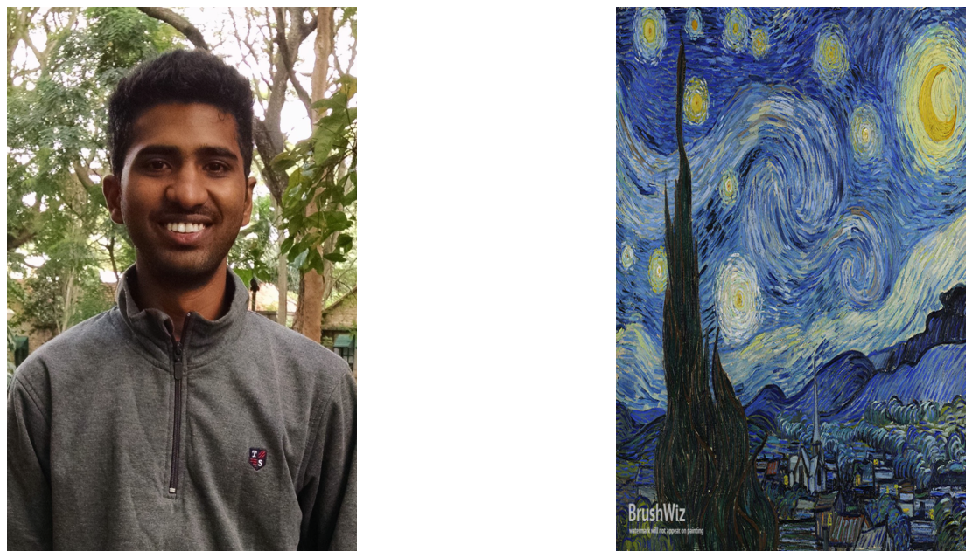

In [11]:
fig=plt.figure(figsize=(20,10))
fig.add_subplot(1,2,1,xticks=[],yticks=[])
plt.imshow(im_convert(content));
fig.add_subplot(1,2,2,xticks=[],yticks=[])
plt.imshow(im_convert(style));

In [0]:
def get_features(img,model,layers=None):
    
    if layers is None:
        layers={'0':'conv1_1',
               '5':'conv2_1',
               '10':'conv3_1',
               '19':'conv4_1',
               '21':'conv4_2',
               '28':'conv5_1'}
    features={}
    x=img
    
    for name,layer in model._modules.items():
        x=layer(x)
        if name in layers:
            features[layers[name]]=x
    
    return features

In [0]:
def gram_matrix(tensor):
    
    batch_size,d,h,w=tensor.shape
    flattened=tensor.view(batch_size,d,-1)
    flattened=flattened.squeeze()
    gram=torch.mm(flattened,flattened.t())
    
    return gram    

In [0]:
content_features=get_features(content,vgg_features)
style_features=get_features(style,vgg_features)

style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

target=content.clone().requires_grad_(True).to(device)

In [0]:
k=style_grams['conv3_1'].numpy()/style_grams['conv3_1'].numpy().max()

In [0]:
plt.imshow(k);

In [0]:
style_weights={'conv1_1':1.,
              'conv2_1':0.8,
              'conv3_1':0.5,
              'conv4_1':0.3,
              'conv5_1':0.1}

content_weight=1
style_weight=1e4

Total loss:  682976.0


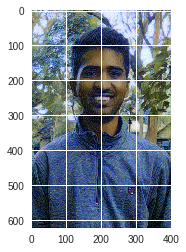

In [22]:
show_every=400

optimizer=optim.Adam([target])
steps=400

for ii in range(1,steps+1):
    
    target_features=get_features(target,vgg_features)
    
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)

    style_loss=0
    
    for layer in style_weights:
        
        target_feature=target_features[layer]
        _,d,h,w=target_feature.shape
        
        target_gram = gram_matrix(target_feature)
        
        style_gram=style_grams[layer]
        
        layer_style_loss= style_weights[layer]*torch.mean((target_gram-style_gram)**2)
        
        style_loss+=layer_style_loss/(d*h*w)
    
    total_loss=content_weight*content_loss+style_weight*style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % show_every==0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show();

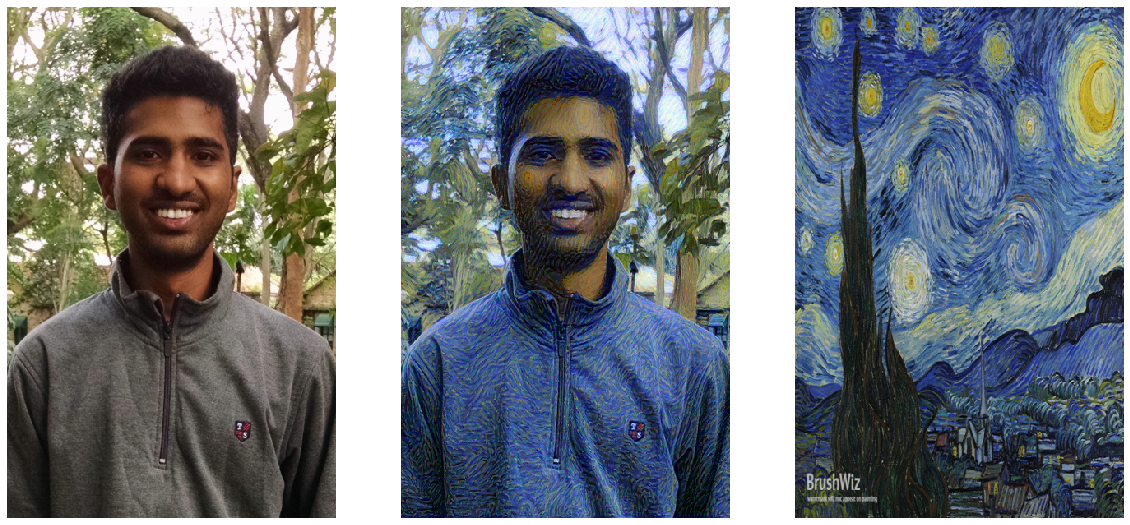

In [23]:
fig=plt.figure(figsize=(20,10))
fig.add_subplot(1,3,1,xticks=[],yticks=[])
plt.imshow(im_convert(content));
fig.add_subplot(1,3,2,xticks=[],yticks=[])
plt.imshow(im_convert(target));
fig.add_subplot(1,3,3,xticks=[],yticks=[])
plt.imshow(im_convert(style));

In [0]:
final=im_convert(target)

In [25]:
final.shape

(623, 400, 3)

In [0]:
plt.imsave('styleImage2.jpg',final)